In [177]:
import xarray as xr
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from scipy.signal import savgol_filter

xarr = xr.open_dataset("data/data_stream-moda.nc")
xarr = xarr.to_array()
# U Eastward, V Northward, T2M 2m Temperature, SP Surface Pressure, TP Total Precipitation

### Visualise variable change for a single pixel

In [ ]:
df = xarr.to_dataframe(name="value").reset_index()
df_mean = (
    df.assign(valid_time=lambda x: pd.to_datetime(x["valid_time"]))
    .assign(value=lambda x: pd.to_numeric(x["value"], errors="coerce"))
    .groupby(["valid_time", "variable"], as_index=False)
    .agg({"value": "mean"})
    .rename(columns={"value": "Original", "valid_time": "Date Time"})
)

# --- Parameters ---
GAUSS_SIGMA = 5
SAVGOL_WINDOW = 15  # Must be odd
SAVGOL_ORDER = 2

smoothed = []

# --- Group and apply smoothing ---
for idx, group in df_mean.groupby("variable"):
    group = group.sort_values("Date Time").copy()
    if idx == "t2m":
        group["Original"] = group["Original"] - 273.15
    elif idx == "tp":
        group["Original"] = group["Original"] * 1000 * 30
    elif idx == "sp":
        group["Original"] = group["Original"] / 100
    val = group["Original"].values
    # Apply Gaussian filter
    group["Gaussian smoothed"] = gaussian_filter1d(val, sigma=GAUSS_SIGMA)

    # Apply Savitzky-Golay filter (only if enough points)
    if len(t2m) >= SAVGOL_WINDOW:
        group["value_savgol"] = savgol_filter(
            val, window_length=SAVGOL_WINDOW, polyorder=SAVGOL_ORDER
        )
    else:
        group["value_savgol"] = np.nan

    smoothed.append(group)

# --- Concatenate back ---
df_smoothed = pd.concat(smoothed).reset_index(drop=True)

df_smoothed = pd.melt(
    df_smoothed,
    id_vars=["Date Time", "variable"],
    value_vars=["Original", "Gaussian smoothed"],  # "value_savgol"
    var_name="type",
    value_name="measurement",
)

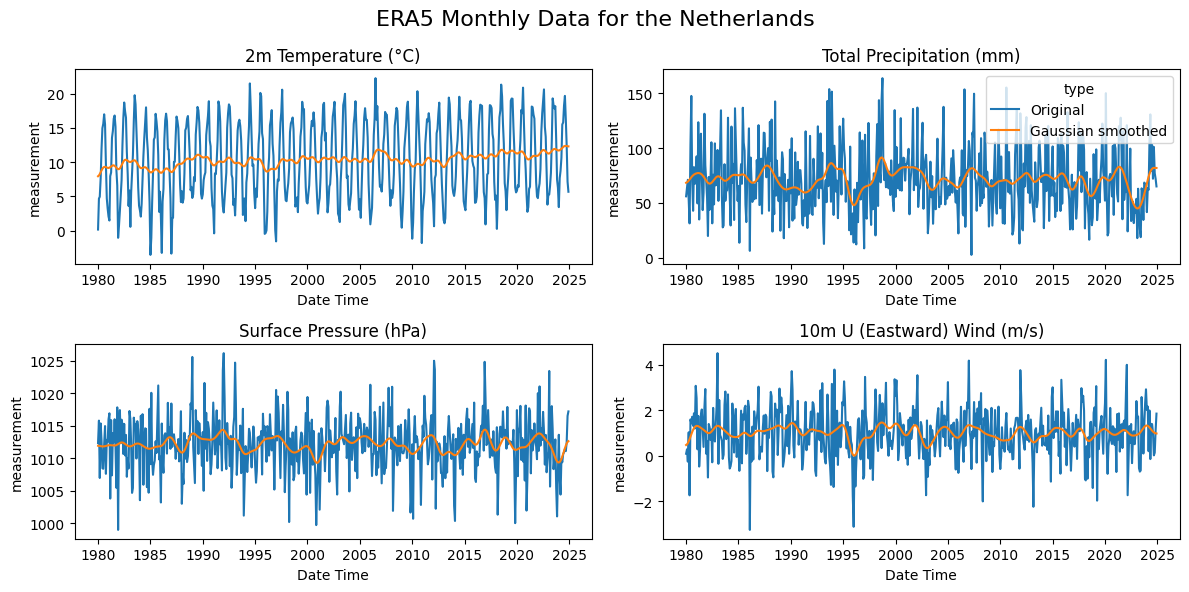

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(12, 6))
sns.lineplot(
    data=df_smoothed[df_smoothed["variable"] == "t2m"],
    x="Date Time",
    y="measurement",
    hue="type",
    # style="type",
    ax=ax[0][0],
    legend=False,
)
sns.lineplot(
    data=df_smoothed[df_smoothed["variable"] == "tp"],
    x="Date Time",
    y="measurement",
    hue="type",
    # style="type",
    ax=ax[0][1],
)
sns.lineplot(
    data=df_smoothed[df_smoothed["variable"] == "sp"],
    x="Date Time",
    y="measurement",
    hue="type",
    # style="type",
    ax=ax[1][0],
    legend=False,
)
sns.lineplot(
    data=df_smoothed[df_smoothed["variable"] == "u10"],
    x="Date Time",
    y="measurement",
    hue="type",
    # style="type",
    ax=ax[1][1],
    legend=False,
)
fig.suptitle("ERA5 Monthly Data for the Netherlands", fontsize=16)
ax[0][0].set_title("2m Temperature (°C)")
ax[0][1].set_title("Total Precipitation (mm)")
ax[1][0].set_title("Surface Pressure (hPa)")
ax[1][1].set_title("10m U (Eastward) Wind (m/s)")
plt.tight_layout()